# Lec 22 - Polynomial Regression and Step Functions
## CMSE 381 - Fall 2023
## Nov 1, 2023



In this module we are going to implement polynomial regression and step functions as discussed in class.

In [1]:
# Everyone's favorite standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time


# ML imports we've used previously
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm


# 0. Loading in the data

We're going to use the `Wage` data used in the book, so note that many of your plots can be checked by looking at figures in the book.

In [2]:
df = pd.read_csv('../../DataSets/Wage.csv', index_col =0 )
df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 231655 to 453557
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   sex         3000 non-null   object 
 3   maritl      3000 non-null   object 
 4   race        3000 non-null   object 
 5   education   3000 non-null   object 
 6   region      3000 non-null   object 
 7   jobclass    3000 non-null   object 
 8   health      3000 non-null   object 
 9   health_ins  3000 non-null   object 
 10  logwage     3000 non-null   float64
 11  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 304.7+ KB


In [4]:
df.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


Here's the plot we used multiple times in class to look at a single variable:  `age` vs `wage`. I've also added some splits so that the people making above and below $250,000 are drawn in a different color.

Text(0, 0.5, 'Wage')

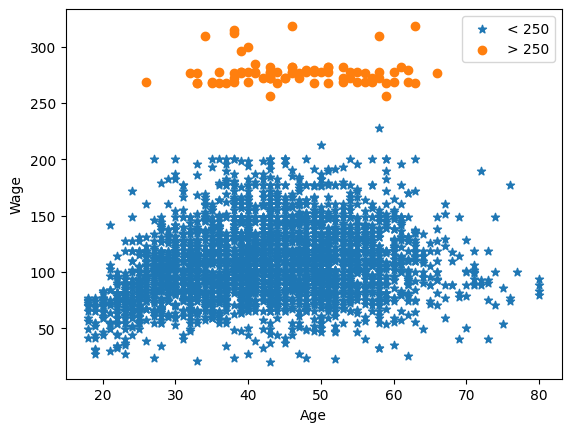

In [5]:
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*', label = '< 250')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250], label = '> 250')
plt.legend()

plt.xlabel('Age')
plt.ylabel('Wage')

## 1. Linear Regression

Before we do anything fancy, let's just do some linear regression. It's not going to be a great fit to our data, this is just to see how we can draw the function learned. 

If I want to learn a linear model predicting `wage` from `age`, I can do the same thing we've done for the last month. 



In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
X = df.age.values.reshape(-1,1)
y = df.wage

linreg = LinearRegression()

linreg.fit(X,y)

LinearRegression()

&#9989; **<font color=red>Do this:</font>** What is the equation learned by the model? 

In [10]:
# your code and or answer here
linreg.coef_

array([0.70727593])

Now I could plot this by taking the equation I just learned and applying it to some vector of values. 

&#9989; **<font color=red>Do this:</font>** Take the vector of values `t_age` below, and plut it into your equation you figured out above to get a vector `y_wage`. 

In [15]:
t_age = np.linspace(20,80)

y_wage = linreg.predict(t_age.reshape(-1,1))

# your code here for y_wage

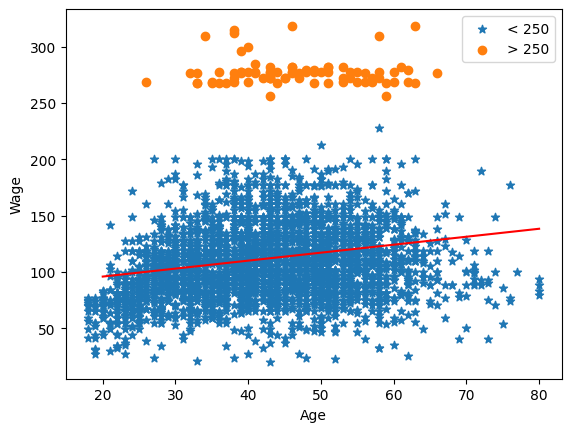

In [16]:
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*', label = '< 250')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250], label = '> 250')
plt.legend()

plt.xlabel('Age')
plt.ylabel('Wage')

# This is what i'm adding to draw the line 

plt.plot(t_age, y_wage, color = 'red')

Now, for plan B in terms of plotting, I can just ask the model to predict values for everything in the `t_age` vector.  It does the same thing, since the innards of the model know how to take a value for `age` and predict `wage`. So the figure below should look exactly the same as your figure above. 

In [17]:
# Now I'm using the sklearn model to figure out my plot!
y_wage = linreg.predict(t_age.reshape(-1,1))

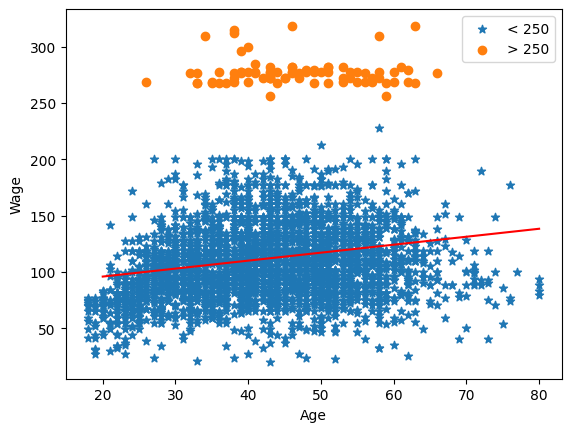

In [18]:
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*', label = '< 250')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250], label = '> 250')
plt.legend()

plt.xlabel('Age')
plt.ylabel('Wage')

# This is what i'm adding to draw the line 

plt.plot(t_age, y_wage, color = 'red')

# 1. Polynomial Regression 

Our first step is to build a polynomial regression model using the age data to predict wage.  So, as in class, we are in $p=1$ world here where we are going to fit the model
$$
\texttt{wage} = \beta_0 + \beta_1 \texttt{age} + \beta_2 \texttt{age}^2 + \cdots + \beta_p \texttt{age}^p +\varepsilon.
$$

The trick here is to build a matrix $X$ which has a column containing `age`, one with `age^2`, one with `age^3`, etc.  Then we hand this to your favorite regression tool (it doesn't need to know it's getting polynomial matrix inputs, it just sees a matrix of features and does it's thing). 

So, here's some code to take our $\texttt{age}$ data column and create a bunch of new columns in our data frame that are simply each the $k$th power of the `age` column

In [19]:
# Here's the column I care about
df.age

231655    18
86582     24
161300    45
155159    43
11443     50
          ..
376816    44
302281    30
10033     27
14375     27
453557    55
Name: age, Length: 3000, dtype: int64

In [20]:
# Here's what the second column should be 
df.age**2

231655     324
86582      576
161300    2025
155159    1849
11443     2500
          ... 
376816    1936
302281     900
10033      729
14375      729
453557    3025
Name: age, Length: 3000, dtype: int64

&#9989; **<font color=red>Do this:</font>** Use the `PolynomialFeatures` command to generate a data frame called `polydf` with columns $\texttt{age}$,  $\texttt{age}^2$,  $\texttt{age}^3$,  $\texttt{age}^4$ like we did a few lectures ago. 




In [21]:
from sklearn.preprocessing import PolynomialFeatures

In [22]:
# Your code here #

poly = PolynomialFeatures(4)

X = poly.fit_transform(df.age.values.reshape(-1,1))

X


array([[1.000000e+00, 1.800000e+01, 3.240000e+02, 5.832000e+03,
        1.049760e+05],
       [1.000000e+00, 2.400000e+01, 5.760000e+02, 1.382400e+04,
        3.317760e+05],
       [1.000000e+00, 4.500000e+01, 2.025000e+03, 9.112500e+04,
        4.100625e+06],
       ...,
       [1.000000e+00, 2.700000e+01, 7.290000e+02, 1.968300e+04,
        5.314410e+05],
       [1.000000e+00, 2.700000e+01, 7.290000e+02, 1.968300e+04,
        5.314410e+05],
       [1.000000e+00, 5.500000e+01, 3.025000e+03, 1.663750e+05,
        9.150625e+06]])

&#9989; **<font color=red>Do this:</font>** Train a linear regression model on these features. What are the coefficients? 


In [33]:

linreg = LinearRegression(fit_intercept=False)

linreg.fit(X,y)

linreg.coef_, linreg.intercept_


(array([-1.84154180e+02,  2.12455205e+01, -5.63859313e-01,  6.81068771e-03,
        -3.20383038e-05]),
 0.0)

&#9989; **<font color=red>Q:</font>** What is the equation for the polynomial that you learned? 

$\hat y = -184+21x-0.56x^2+0.006x^3-0.00003x^4$

&#9989; **<font color=red>Do this:</font>** As before, determine `y_wage` from the `t_age` input below by using the polynomial you figured out above. Then the code below should plot your function. 

In [27]:
t_age = np.linspace(10,90,100)

# Your code here to determine y_wage

y_wage = linreg.predict(poly.fit_transform(t_age.reshape(-1,1)))


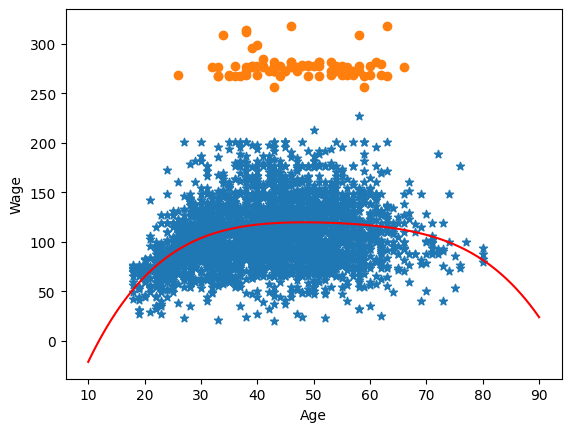

In [28]:
# Note: this should look like and the next slide in the notes.
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250])

plt.xlabel('Age')
plt.ylabel('Wage')

plt.plot(t_age, y_wage, c= 'red')

&#9989; **<font color=red>Do this:</font>** Do the same thing again by predicting `y_wage` using the linear regression model you just used. 

*Hint: the `linreg` trained wants a matrix of values, not just a single column. What do you need to do to `t_age` to pass it into the linear regression model? 

In [35]:
t_age = np.linspace(10,90,100)

# Your code here to get y_wage 
print(t_age.shape)
print(poly.fit_transform(t_age.reshape(-1,1)).shape)

y_wage = linreg.predict(poly.fit_transform(t_age.reshape(-1,1)))

(100,)
(100, 5)


Text(0, 0.5, 'Wage')

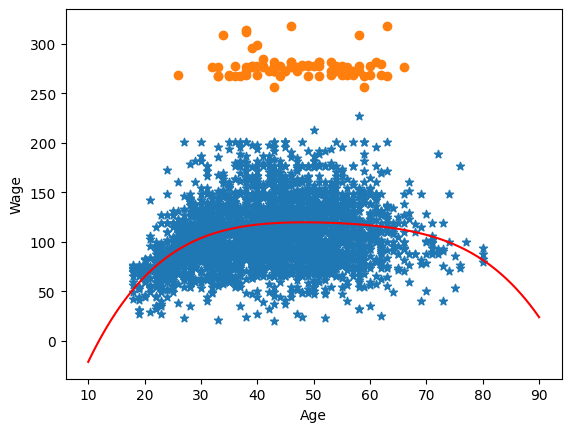

In [31]:
# Note: If it worked, this should look exactly the same as the plot above. 
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250])

plt.plot(t_age,y_wage, c= 'red')
plt.xlabel('Age')
plt.ylabel('Wage')


![Stop Icon](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Vienna_Convention_road_sign_B2a.svg/180px-Vienna_Convention_road_sign_B2a.svg.png)

Great, you got to here! Hang out for a bit, there's more lecture before we go on to the next portion. 

# 2. Step functions

Now let's try to use step functions to learn a model using `age` to predict `wage`. Like with the polynomial example from last time, all we're going to do is build a data frame or feature matrix that has the step function values in each column, and then pass that matrix to our favorite linear modeling function. 

First, we want to get a dataframe with the cuts. 

In [ ]:
df_cut, bins = pd.cut(df.age, 4, retbins = True, right = False)

Note that the `df_cut` is a pandas series with each data point now represented as the interval it's contained in. 

In [ ]:
df_cut

Here I'm just printing it out in a column next to the `age` information that was used to generate it.

In [ ]:
pd.DataFrame({'age': df.age, 'df_cut': df_cut})

The `bins` output gives me the $c_i$'s as follows. 


In [ ]:
print(bins)

In [ ]:
# This is how it matches with our notation.
print(r'c_1 = ', bins[0])
print(r'c_2 = ', bins[1])
print(r'c_3 = ', bins[2])
print(r'c_4 = ', bins[3])
print(r'c_5 = ', bins[4])

&#9989; **<font color=red>Do this:</font>**
 For each of the functions $C_0(X)$, $C_1(X)$, $C_2(X)$, $C_3(X)$, $C_4(X)$, $C_5(X)$ (following our notation in class), determine the domains where they have value 1. 

*Your answer here*

- $C_0(X)$:
- $C_1(X)$:
- $C_2(X)$: 
- $C_3(X)$: 
- $C_4(X)$: 
- $C_5(X)$: 

Below is my code that generates the data frame storing $C_i(X)$ for all our entries. 

In [ ]:
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.head()

As with our other uses of dummy variables, I don't actually need all of them. I can just include three since I can always figure out the entry of the first based on the rest. It doesn't actually matter which one you drop (as long as you interpret proplerly after the fact) so for the sake of making the notation no worse than it already is I'm going to drop the last one. (*Note I could use `drop_first = True` instead, again just with some slight changes in interpretation later*)

In [ ]:
df_steps_dummies = df_steps_dummies.iloc[:,:3]
df_steps_dummies.head()

&#9989; **<font color=red>Q:</font>** Which of the functions $C_i(X)$ for $i=0,\cdots, 5$ have columns represented in this matrix? *Note: it's not all of them*


* Your answer here*

&#9989; **<font color=red>Do this:</font>** Pass this matrix to a linear regression model and use it to predict `wage`. What is the equation for your learned model? Be specific in terms of the $C_i$ functions you learned earlier.

In [ ]:
# Your code here #

&#9989; **<font color=red>Do this:</font>** Using the function $f(X)$ you just learned, what is the function value on each of the following values of $X$?

| X  | f(X)| 
| ---| --- | 
| 10 |     |
| 20 |     |
| 30 |     | 
| 40 |     |
| 50 |     | 
| 60 |     | 
| 70 |     |
| 80 |     |



Assuming you stored your linear regression model as `linreg`, the following code will plot the learned function. Check that the answers you got in the table above match with what you're seeing in the graph.  

In [ ]:
t_age = np.linspace(10,80,100)

# First I need to do the same transformation on my t inputs that 
# I did on the original data for this to work!!! The only weird 
# thing is that it doesn't remember my column names, but we're still doing the same thing here. 
bin_mapping = np.digitize(t_age, bins)
t_dummies = pd.get_dummies(bin_mapping)
t_dummies = t_dummies.drop(columns =[0,4])

# Manually putting the column names back to aleviate confusion
# This step isn't really necessary for prediction, just for understanding.
t_dummies.columns = df_steps_dummies.columns
t_dummies.head()

&#9989; **<font color=red>Do this:</font>** Above, I figured out the transformation of the input `t_age` values to do the same transformation as our step function. Now use the linear regression model learned to predict `y_wage`, then we can graph it. 

In [ ]:
# your code here

# y_wage = .......

In [ ]:
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250])
plt.xlabel('Age')
plt.ylabel('Wage')

plt.plot(t,stepPredict,color='red')



-----
### Congratulations, we're done!
Written by Dr. Liz Munch, Michigan State University

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.